In [ ]:
!pip install qiskit[visualization]==1.0.2
!pip install qiskit_aer
!pip install qiskit_ibm_runtime
!pip install matplotlib

!pip install pylatexenc
!pip install qiskit-transpiler-service
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 2.7 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=349d2d94c1f91da7bc7c278eb39370fe31ac60f1add2a9e92f3e7e9e7386748a
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
import qiskit
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit import assemble
from qiskit.circuit.library import MCXGate
# import basic plot tools
from qiskit.visualization import plot_histogram
import pennylane as qml

from qiskit.quantum_info import Statevector
from qiskit_aer import StatevectorSimulator
from qiskit.circuit.instruction import Instruction
from qiskit.exceptions import QiskitError
from qiskit.quantum_info.operators.channel.quantum_channel import QuantumChannel
from qiskit.quantum_info.operators.channel.superop import SuperOp
from qiskit.quantum_info.operators.channel.transformations import _to_ptm
from qiskit.quantum_info.operators.mixins import generate_apidocs
from qiskit_aer import AerSimulator


In [ ]:
def grover2(repetitions):
  for i in range(2):
    qml.Hadamard(wires=i)
  qml.CZ(wires=[0,1])

  qml.Barrier()
  #diffusion
  qml.Hadamard(wires=0)
  qml.Hadamard(wires=1)
  qml.X(wires=0)
  qml.X(wires=1)
  qml.CZ(wires=[0,1])
  qml.X(wires=0)
  qml.X(wires=1)
  qml.Hadamard(wires=0)
  qml.Hadamard(wires=1)

  return qml.probs(wires=range(2))

(<Figure size 1100x300 with 1 Axes>, <Axes: >)

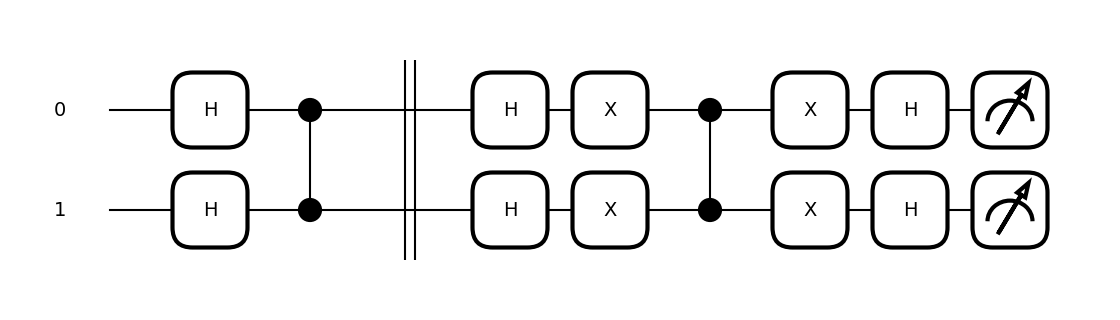

In [ ]:
qml.draw_mpl(grover2)(repetitions=1)

In [ ]:
def _2wqcgrover2():
  for i in range(2):
    qml.Hadamard(wires=i)
  qml.MultiControlledX(wires=[0,1,2])

  return qml.state()


(<Figure size 500x400 with 1 Axes>, <Axes: >)

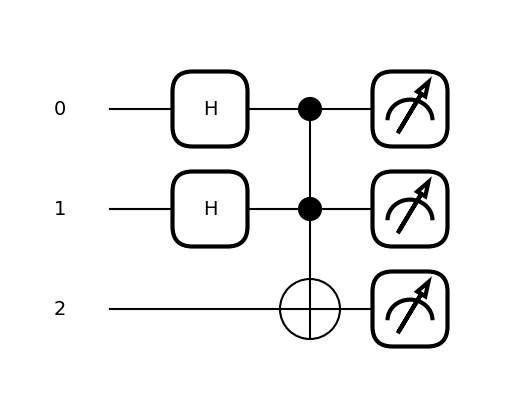

In [ ]:
qml.draw_mpl(_2wqcgrover2)()

In [ ]:
def success_prob_grover(repetitions, noise_gate, noise_strength):
    '''
    Returns the probability of success for a given number of repetitions, noise type and noise level, in the case of the standard Grover's algorithm.
    '''
    dev_ideal = qml.device("default.mixed", wires=3)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)
    circ = qml.QNode(grover2, dev_noisy)
    full_state = circ(repetitions)

    return np.real_if_close(full_state[3])

In [ ]:
def success_prob_2wqc(noise_gate, noise_strength):
    '''
    Returns the probability of success for a given noise type and noise level, in the case of the 2WQC version of Grover's algorithm.
    '''
    dev_ideal = qml.device("default.mixed", wires=3)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)

    circ = qml.QNode(_2wqcgrover2, dev_noisy)
    full_state = circ()
    #eps=desired value [0...1] and change [0,1] ---> [eps,1-eps] for error in <1| operation

    op = np.kron(np.eye(4),[[0,1]])

    reduced_state = op.dot(full_state).dot(op.conj().T)
    # print(reduced_state)
    reduced_state = reduced_state/reduced_state.trace()

    return np.real_if_close(reduced_state.diagonal()[3])

In [ ]:
# description of noise by type of gate and strength

# noise_gate = qml.BitFlip
# noise_gate = qml.PhaseFlip
# noise_gate = qml.PhaseDamping
noise_gate = qml.DepolarizingChannel

noise_strength = 0.1

noise = np.linspace(0,1,100)


In [ ]:
prob_2wqc = [success_prob_2wqc(noise_gate=noise_gate, noise_strength=_) for _ in noise]
print(np.shape(prob_2wqc))


(100,)


In [ ]:
prob_grover_1 = [success_prob_grover(repetitions=1, noise_gate=noise_gate, noise_strength=_) for _ in noise]
print(np.shape(prob_grover_1))


(100,)


Text(0, 0.5, 'Success probability')

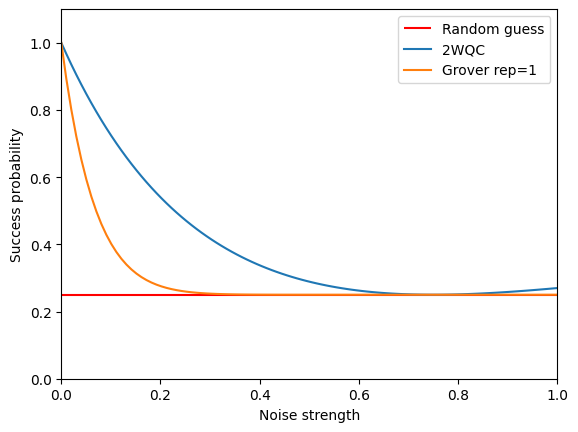

In [ ]:
plt.hlines(1/4,0,1, color='red', label='Random guess')
plt.plot(noise, prob_2wqc, '-', label='2WQC')
plt.plot(noise, prob_grover_1, '-', label='Grover rep=1')
plt.ylim(0,1.1)
plt.xlim(0,1)
plt.legend()
plt.xlabel('Noise strength')
plt.ylabel('Success probability')

# 3qubit grover 2wqc analysis

In [ ]:
def grover3(repetitions):
  for i in range(3):
    qml.Hadamard(wires=i)
  for i in range(repetitions):
    qml.Hadamard(wires=2)
    qml.MultiControlledX(wires=[0,1,2])
    qml.Hadamard(wires=2)

    qml.Barrier()
  # diff

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)

    qml.X(wires=0)
    qml.X(wires=1)
    qml.X(wires=2)

    qml.Barrier()
    qml.Hadamard(wires=2)
    qml.MultiControlledX(wires=[0,1,2])
    qml.Hadamard(wires=2)
    qml.Barrier()

    qml.X(wires=0)
    qml.X(wires=1)
    qml.X(wires=2)

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)

    qml.Barrier()


  return qml.probs(wires=range(3))


(<Figure size 1800x400 with 1 Axes>, <Axes: >)

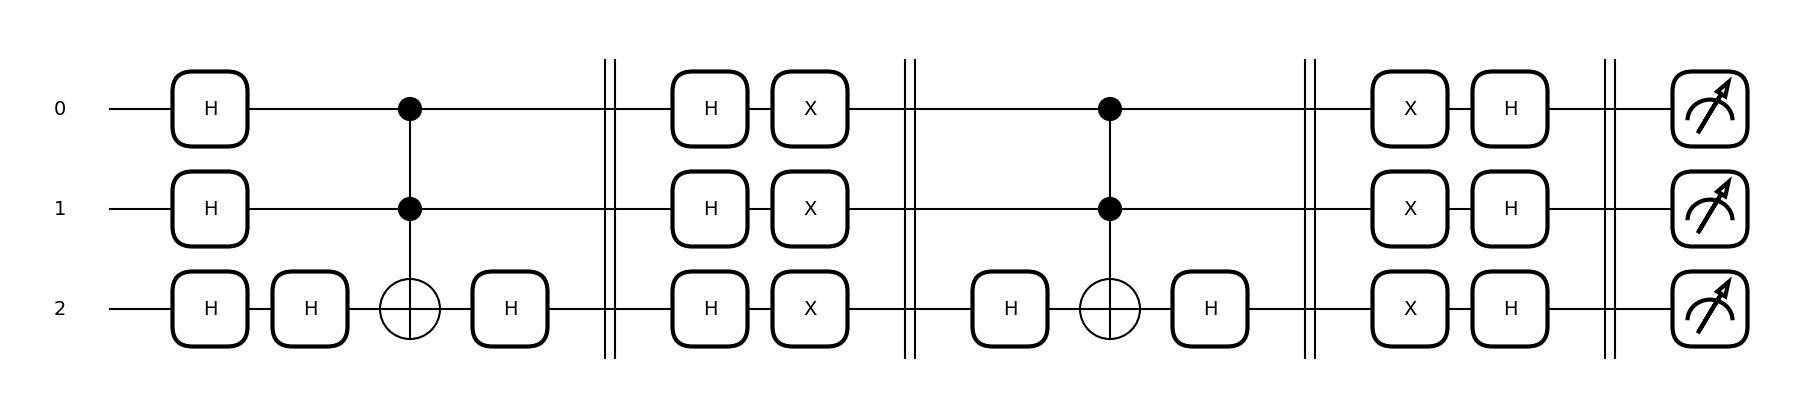

In [ ]:
qml.draw_mpl(grover3)(repetitions=1)

In [ ]:
def _2wqcgrover3():
  for i in range(3):
    qml.Hadamard(wires=i)
  qml.MultiControlledX(wires=[0,1,2,3])

  return qml.state()

(<Figure size 500x500 with 1 Axes>, <Axes: >)

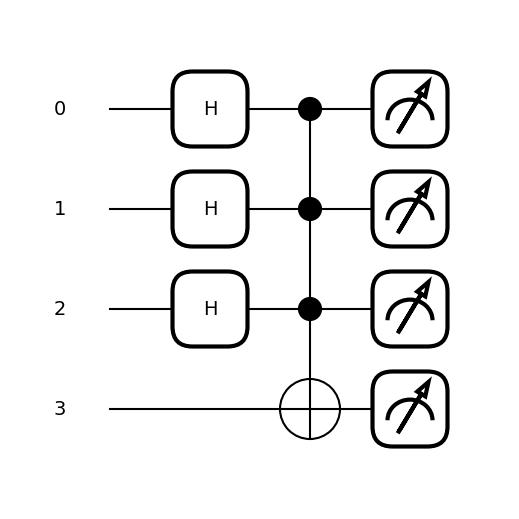

In [ ]:
qml.draw_mpl(_2wqcgrover3)()

In [ ]:
def success_prob_grover3(repetitions, noise_gate, noise_strength):
    '''
    Returns the probability of success for a given number of repetitions, noise type and noise level, in the case of the standard Grover's algorithm.
    '''
    dev_ideal = qml.device("default.mixed", wires=4)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)
    circ = qml.QNode(grover3, dev_noisy)
    full_state = circ(repetitions)

    return np.real_if_close(full_state[7])

In [ ]:
def success_prob_2wqcgrover3(noise_gate, noise_strength):
    '''
    Returns the probability of success for a given noise type and noise level, in the case of the 2WQC version of Grover's algorithm.
    '''
    dev_ideal = qml.device("default.mixed", wires=4)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)

    circ = qml.QNode(_2wqcgrover3, dev_noisy)
    full_state = circ()
    #eps=desired value [0...1] and change [0,1] ---> [eps,1-eps] for error in <1| operation

    op = np.kron(np.eye(8),[[0,1]])

    reduced_state = op.dot(full_state).dot(op.conj().T)
    # print(reduced_state)
    reduced_state = reduced_state/reduced_state.trace()

    return np.real_if_close(reduced_state.diagonal()[7])

In [ ]:
# description of noise by type of gate and strength

# noise_gate = qml.BitFlip
# noise_gate = qml.PhaseFlip
# noise_gate = qml.PhaseDamping
noise_gate = qml.DepolarizingChannel

noise_strength = 0.1

noise = np.linspace(0,1,100)


In [ ]:
prob_2wqc_grover3 = [success_prob_2wqcgrover3(noise_gate=noise_gate, noise_strength=_) for _ in noise]


In [ ]:
prob_grover3_1 = [success_prob_grover3(repetitions=2, noise_gate=noise_gate, noise_strength=_) for _ in noise]


Text(0, 0.5, 'Success probability')

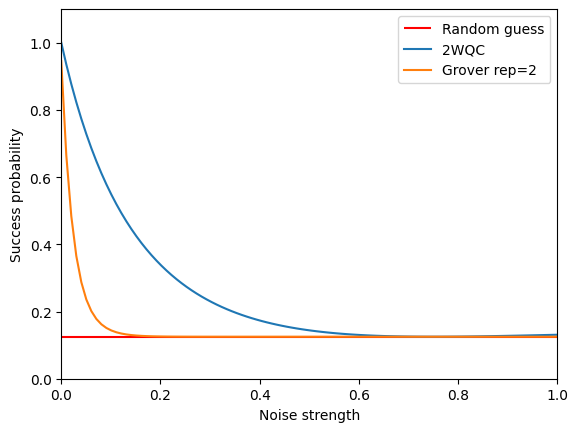

In [ ]:
plt.hlines(1/8,0,1, color='red', label='Random guess')
plt.plot(noise, prob_2wqc_grover3, '-', label='2WQC')
plt.plot(noise, prob_grover3_1, '-', label='Grover rep=2')
plt.ylim(0,1.1)
plt.xlim(0,1)
plt.legend()
plt.xlabel('Noise strength')
plt.ylabel('Success probability')

# 4qubit grover

In [ ]:
def grover4(repetitions):
  for i in range(4):
    qml.Hadamard(wires=i)

  for i in range (repetitions):

    qml.Hadamard(wires=3)
    qml.MultiControlledX(wires=[0,1,2,3])
    qml.Hadamard(wires=3)

    qml.Barrier()

  # diff

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)

    qml.X(wires=0)
    qml.X(wires=1)
    qml.X(wires=2)
    qml.X(wires=3)

    qml.Barrier()

    qml.Hadamard(wires=3)
    qml.MultiControlledX(wires=[0,1,2,3])
    qml.Hadamard(wires=3)

    qml.Barrier()

    qml.X(wires=0)
    qml.X(wires=1)
    qml.X(wires=2)
    qml.X(wires=3)

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)


    qml.Barrier()

  return qml.probs(wires=range(4))

(<Figure size 4600x500 with 1 Axes>, <Axes: >)

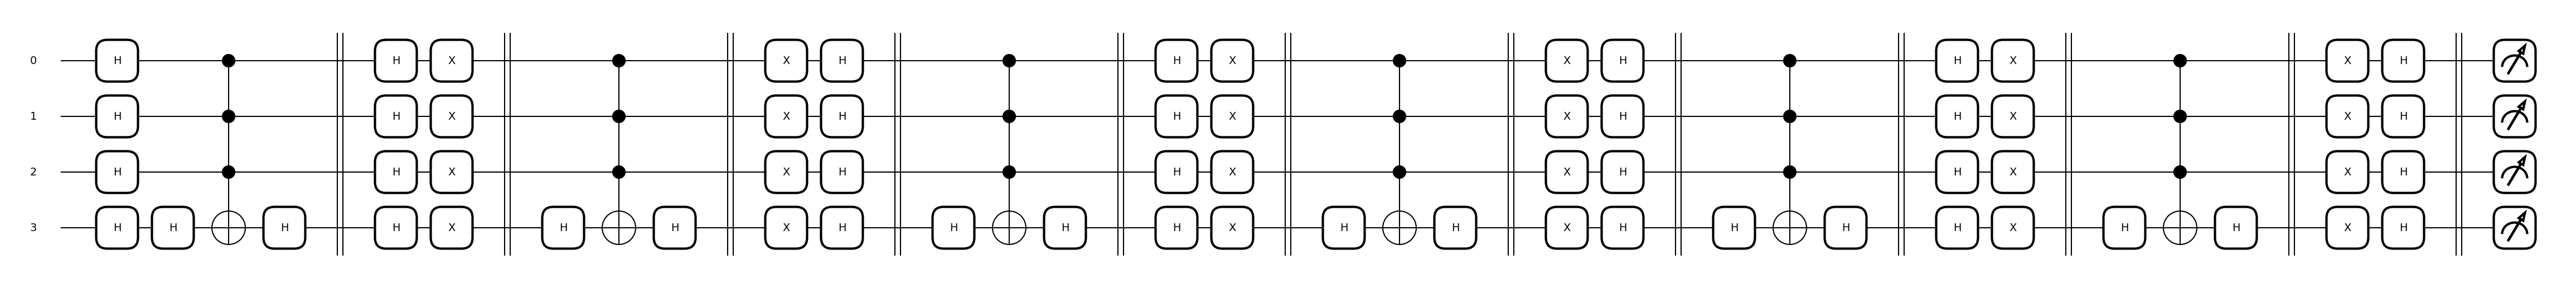

In [ ]:
qml.draw_mpl(grover4)(repetitions=3)

In [ ]:
def _2wqcgrover4():
  for i in range(4):
    qml.Hadamard(wires=i)
  qml.MultiControlledX(wires=[0,1,2,3,4])

  return qml.state()

(<Figure size 500x600 with 1 Axes>, <Axes: >)

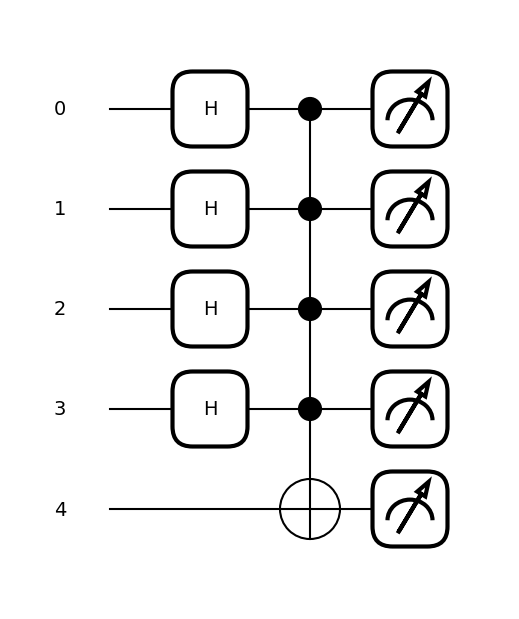

In [ ]:
qml.draw_mpl(_2wqcgrover4)()

In [ ]:
def success_prob_grover4(repetitions, noise_gate, noise_strength):
    '''
    Returns the probability of success for a given number of repetitions, noise type and noise level, in the case of the standard Grover's algorithm.
    '''
    dev_ideal = qml.device("default.mixed", wires=5)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)
    circ = qml.QNode(grover4, dev_noisy)
    full_state = circ(repetitions)

    return np.real_if_close(full_state[15])

In [ ]:
def success_prob_2wqcgrover4(noise_gate, noise_strength):
    '''
    Returns the probability of success for a given noise type and noise level, in the case of the 2WQC version of Grover's algorithm.
    '''
    dev_ideal = qml.device("default.mixed", wires=5)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)

    circ = qml.QNode(_2wqcgrover4, dev_noisy)
    full_state = circ()
    #eps=desired value [0...1] and change [0,1] ---> [eps,1-eps] for error in <1| operation

    op = np.kron(np.eye(16),[[0,1]])

    reduced_state = op.dot(full_state).dot(op.conj().T)
    # print(reduced_state)
    reduced_state = reduced_state/reduced_state.trace()

    return np.real_if_close(reduced_state.diagonal()[15])

In [ ]:
# description of noise by type of gate and strength

# noise_gate = qml.BitFlip
# noise_gate = qml.PhaseFlip
# noise_gate = qml.PhaseDamping
noise_gate = qml.DepolarizingChannel

noise_strength = 0.1

noise = np.linspace(0,1,100)

In [ ]:
prob_2wqc_grover4 = [success_prob_2wqcgrover4(noise_gate=noise_gate, noise_strength=_) for _ in noise]


In [ ]:

prob_grover4_1 = [success_prob_grover4(repetitions=3, noise_gate=noise_gate, noise_strength=_) for _ in noise]


Text(0, 0.5, 'Success probability')

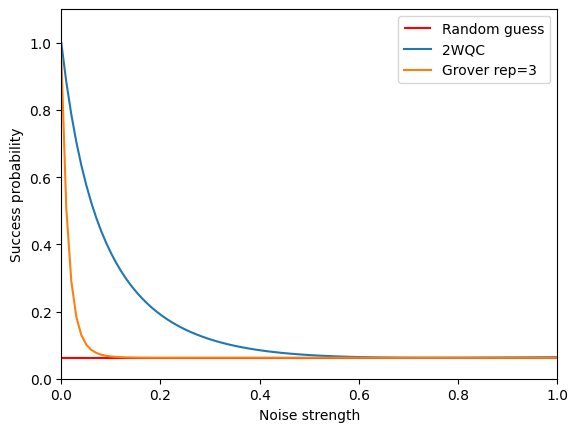

In [ ]:
plt.hlines(1/16,0,1, color='red', label='Random guess')
plt.plot(noise, prob_2wqc_grover4, '-', label='2WQC')
plt.plot(noise, prob_grover4_1, '-', label='Grover rep=3')
plt.ylim(0,1.1)
plt.xlim(0,1)
plt.legend()
plt.xlabel('Noise strength')
plt.ylabel('Success probability')

# 5 qubit Std Grover

In [ ]:
def grover5(repetitions):
  for i in range(5):
    qml.Hadamard(wires=i)

  for i in range(repetitions):

    qml.Hadamard(wires=4)
    qml.MultiControlledX(wires=[0,1,2,3,4])
    qml.Hadamard(wires=4)

    qml.Barrier()
    # diff

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)
    qml.Hadamard(wires=4)

    qml.X(wires=0)
    qml.X(wires=1)
    qml.X(wires=2)
    qml.X(wires=3)
    qml.X(wires=4)

    qml.Barrier()

    qml.Hadamard(wires=4)
    qml.MultiControlledX(wires=[0,1,2,3,4])
    qml.Hadamard(wires=4)

    qml.Barrier()

    qml.X(wires=0)
    qml.X(wires=1)
    qml.X(wires=2)
    qml.X(wires=3)
    qml.X(wires=4)

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)
    qml.Hadamard(wires=4)

    qml.Barrier()

  return qml.probs(wires=range(5))

(<Figure size 6000x600 with 1 Axes>, <Axes: >)

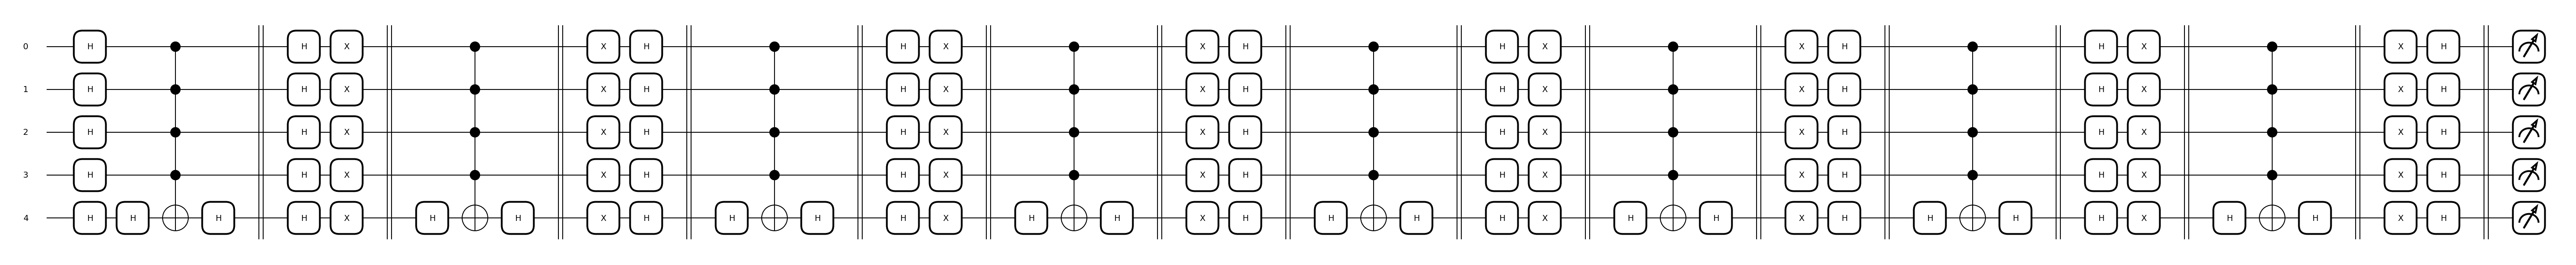

In [ ]:
qml.draw_mpl(grover5)(repetitions=4)

In [ ]:
def _2wqcgrover5():
  for i in range(5):
    qml.Hadamard(wires=i)
  qml.MultiControlledX(wires=[0,1,2,3,4,5])

  return qml.state()

(<Figure size 500x700 with 1 Axes>, <Axes: >)

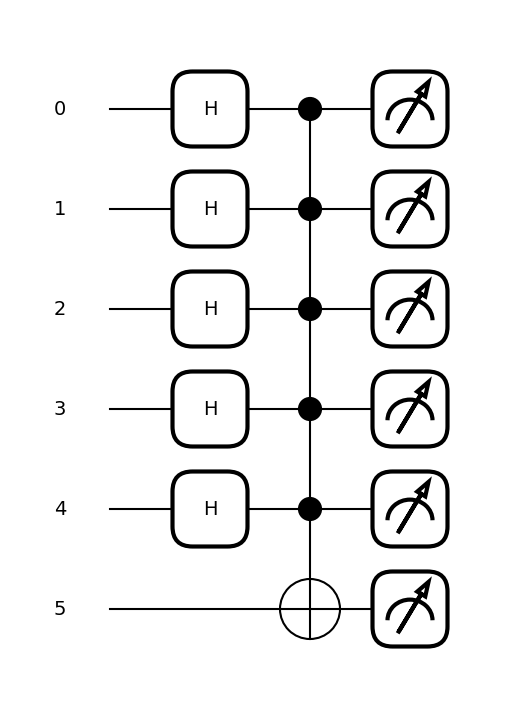

In [ ]:
qml.draw_mpl(_2wqcgrover5)()

In [ ]:
def success_prob_grover5(repetitions, noise_gate, noise_strength):
    '''
    Returns the probability of success for a given number of repetitions, noise type and noise level, in the case of the standard Grover's algorithm.
    '''
    dev_ideal = qml.device("default.mixed", wires=6)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)
    circ = qml.QNode(grover5, dev_noisy)
    full_state = circ(repetitions)

    return np.real_if_close(full_state[31])

In [ ]:
def success_prob_2wqcgrover5(noise_gate, noise_strength):
    '''
    Returns the probability of success for a given noise type and noise level, in the case of the 2WQC version of Grover's algorithm.
    '''
    dev_ideal = qml.device("default.mixed", wires=6)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)

    circ = qml.QNode(_2wqcgrover5, dev_noisy)
    full_state = circ()
    #eps=desired value [0...1] and change [0,1] ---> [eps,1-eps] for error in <1| operation
    op = np.kron(np.eye(32),[[0,1]])

    reduced_state = op.dot(full_state).dot(op.conj().T)
    # print(reduced_state)
    reduced_state = reduced_state/reduced_state.trace()

    return np.real_if_close(reduced_state.diagonal()[31])

In [ ]:
# description of noise by type of gate and strength

# noise_gate = qml.BitFlip
# noise_gate = qml.PhaseFlip
# noise_gate = qml.PhaseDamping
noise_gate = qml.DepolarizingChannel

noise_strength = 0.1

noise = np.linspace(0,1,100)

In [ ]:
prob_2wqc_grover5 = [success_prob_2wqcgrover5(noise_gate=noise_gate, noise_strength=_) for _ in noise]


In [ ]:
prob_grover5_1 = [success_prob_grover5(repetitions=4, noise_gate=noise_gate, noise_strength=_) for _ in noise]


Text(0, 0.5, 'Success probability')

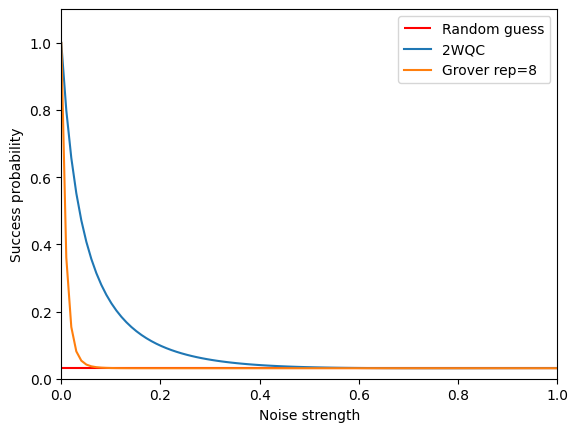

In [ ]:
plt.hlines(1/32,0,1, color='red', label='Random guess')
plt.plot(noise, prob_2wqc_grover5, '-', label='2WQC')
plt.plot(noise, prob_grover5_1, '-', label='Grover rep=8')
plt.ylim(0,1.1)
plt.xlim(0,1)
plt.legend()
plt.xlabel('Noise strength')
plt.ylabel('Success probability')

# Std Grover 6 qubit

In [ ]:
def grover6(repetitions):
  for i in range(6):
    qml.Hadamard(wires=i)
  for i in range(repetitions):

    qml.Hadamard(wires=5)
    qml.MultiControlledX(wires=[0,1,2,3,4,5])
    qml.Hadamard(wires=5)

    qml.Barrier()
    # diff

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)
    qml.Hadamard(wires=4)
    qml.Hadamard(wires=5)

    qml.X(wires=0)
    qml.X(wires=1)
    qml.X(wires=2)
    qml.X(wires=3)
    qml.X(wires=4)
    qml.X(wires=5)

    qml.Barrier()
    qml.Hadamard(wires=5)
    qml.MultiControlledX(wires=[0,1,2,3,4,5])
    qml.Hadamard(wires=5)
    qml.Barrier()

    qml.X(wires=0)
    qml.X(wires=1)
    qml.X(wires=2)
    qml.X(wires=3)
    qml.X(wires=4)
    qml.X(wires=5)

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)
    qml.Hadamard(wires=4)
    qml.Hadamard(wires=5)


    qml.Barrier()

  return qml.probs(wires=range(6))

(<Figure size 7400x700 with 1 Axes>, <Axes: >)

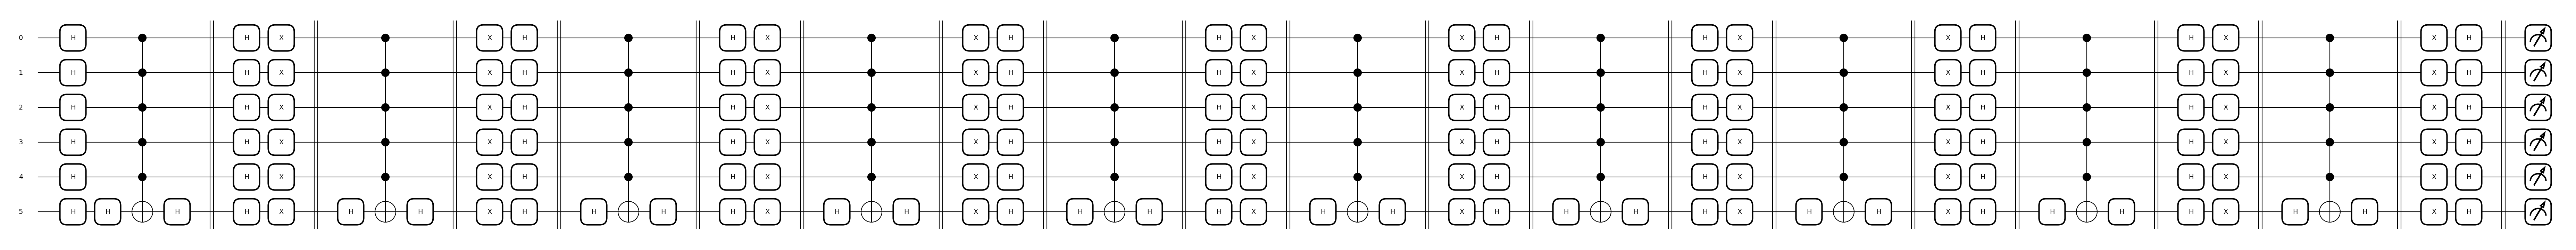

In [ ]:
qml.draw_mpl(grover6)(repetitions=5)

In [ ]:
def _2wqcgrover6():
  for i in range(6):
    qml.Hadamard(wires=i)
  qml.MultiControlledX(wires=[0,1,2,3,4,5,6])

  return qml.state()

(<Figure size 500x800 with 1 Axes>, <Axes: >)

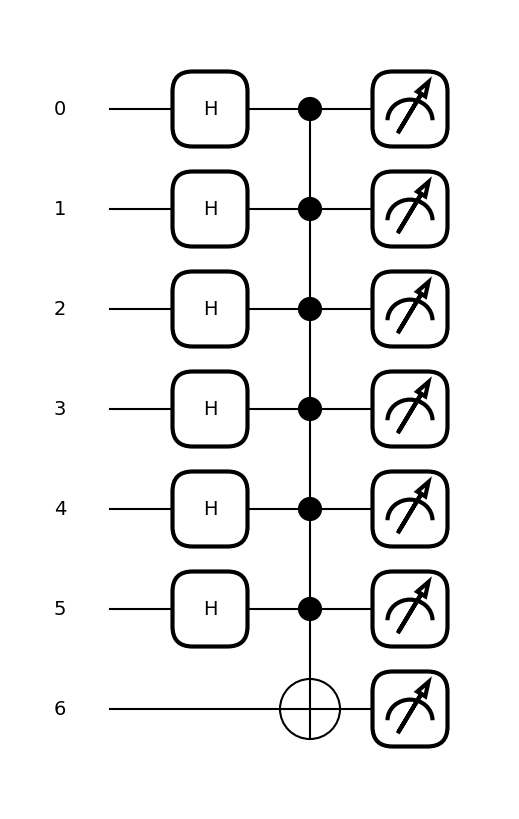

In [ ]:
qml.draw_mpl(_2wqcgrover6)()

In [ ]:
def success_prob_grover6(repetitions, noise_gate, noise_strength):
    '''
    Returns the probability of success for a given number of repetitions, noise type and noise level, in the case of the standard Grover's algorithm.
    '''
    dev_ideal = qml.device("default.mixed", wires=7)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)
    circ = qml.QNode(grover6, dev_noisy)
    full_state = circ(repetitions)

    return np.real_if_close(full_state[63])

In [ ]:
def success_prob_2wqcgrover6(noise_gate, noise_strength):
    '''
    Returns the probability of success for a given noise type and noise level, in the case of the 2WQC version of Grover's algorithm.
    '''
    dev_ideal = qml.device("default.mixed", wires=7)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)

    circ = qml.QNode(_2wqcgrover6, dev_noisy)
    full_state = circ()
    #eps=desired value [0...1] and change [0,1] ---> [eps,1-eps] for error in <1| operation

    op = np.kron(np.eye(64),[[0,1]])

    reduced_state = op.dot(full_state).dot(op.conj().T)
    # print(reduced_state)
    reduced_state = reduced_state/reduced_state.trace()

    return np.real_if_close(reduced_state.diagonal()[63])

In [ ]:
# description of noise by type of gate and strength

# noise_gate = qml.BitFlip
# noise_gate = qml.PhaseFlip
# noise_gate = qml.PhaseDamping
noise_gate = qml.DepolarizingChannel

noise_strength = 0.1

noise = np.linspace(0,1,100)

In [ ]:
prob_2wqc_grover6 = [success_prob_2wqcgrover6(noise_gate=noise_gate, noise_strength=_) for _ in noise]


In [ ]:
prob_grover6_1 = [success_prob_grover6(repetitions=5, noise_gate=noise_gate, noise_strength=_) for _ in noise]


Text(0, 0.5, 'Success probability')

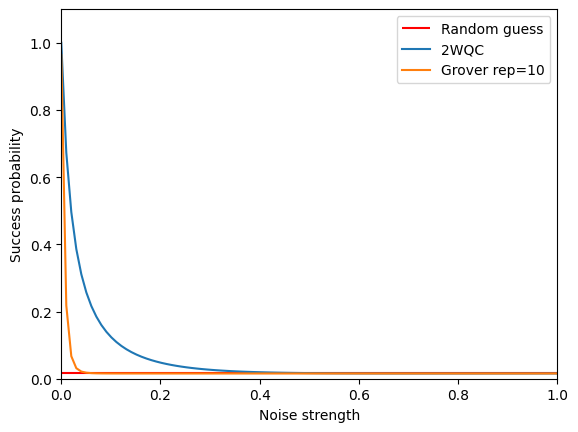

In [ ]:
plt.hlines(1/64,0,1, color='red', label='Random guess')
plt.plot(noise, prob_2wqc_grover6, '-', label='2WQC')
plt.plot(noise, prob_grover6_1, '-', label='Grover rep=10')
plt.ylim(0,1.1)
plt.xlim(0,1)
plt.legend()
plt.xlabel('Noise strength')
plt.ylabel('Success probability')

Text(0, 0.5, 'Success probability')

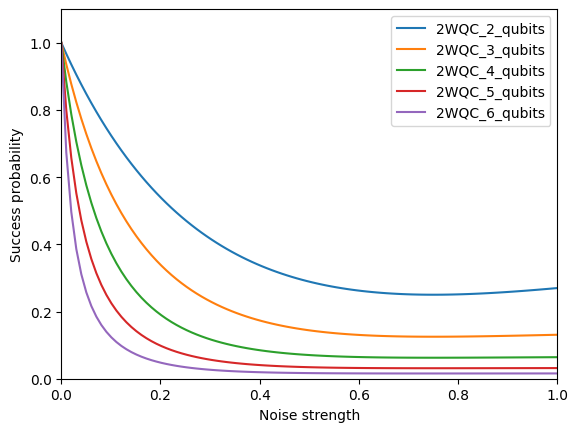

In [ ]:
plt.plot(noise, prob_2wqc, '-', label='2WQC_2_qubits')
plt.plot(noise, prob_2wqc_grover3, '-', label='2WQC_3_qubits')
plt.plot(noise, prob_2wqc_grover4, '-', label='2WQC_4_qubits')
plt.plot(noise, prob_2wqc_grover5, '-', label='2WQC_5_qubits')
plt.plot(noise, prob_2wqc_grover6, '-', label='2WQC_6_qubits')
plt.ylim(0,1.1)
plt.xlim(0,1)
plt.legend()
plt.xlabel('Noise strength')
plt.ylabel('Success probability')